In [3]:
#importing the libraries
import torch
import torch.nn as nn
from torch.nn import functional as  F

#setting the device
device="cuda" if torch.cuda.is_available() else "cpu"

#HYPER-PARAMETERS
block_size=8
batch_size=8
max_iters=1000
learning_rate=3e-3
eval_iters=250
n_embed=384
n_layers=4

In [ ]:
with open("wizard_of_oz.txt", 'r', encoding="utf-8") as f:
    text=f.read()
vacab_size = len(chars)

In [ ]:
# to make sure pytorch does not use gradients for computation, this is done to reduce the computation time
@torch.no_grad()
def estimate_loss():
    out={}
    model.eval()
    for split in ["train","val"]:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y=get_batch(split)
            logits, loss=model(X,Y)
            losses[k]=loss.item()
        out[split]=losses.mean()
    model.train()
    return out

# artitecure defination

1) input and embeding with positionla embedding
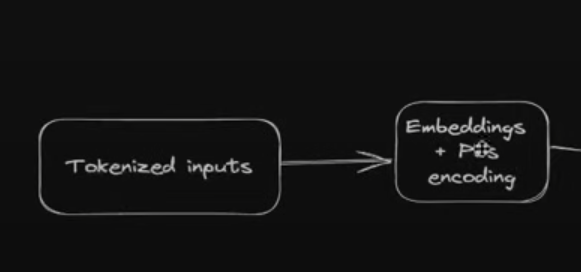

2) 4 decoder block
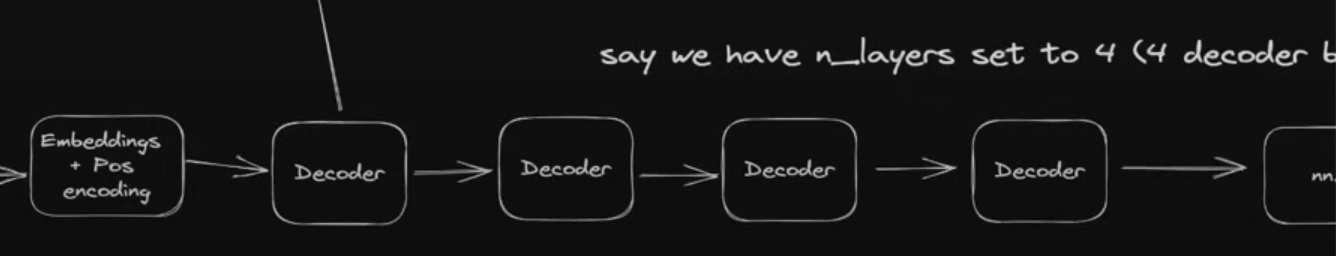

3) normalization layer

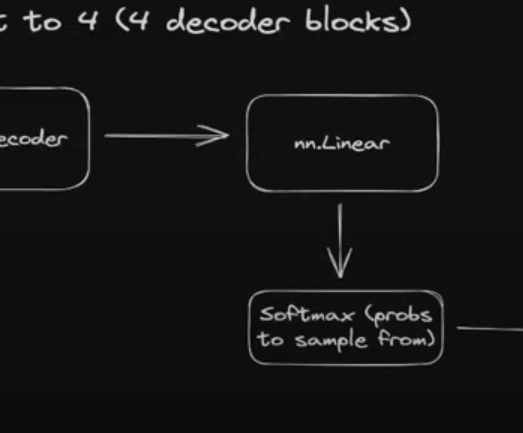

4)probablity distribution using softmax
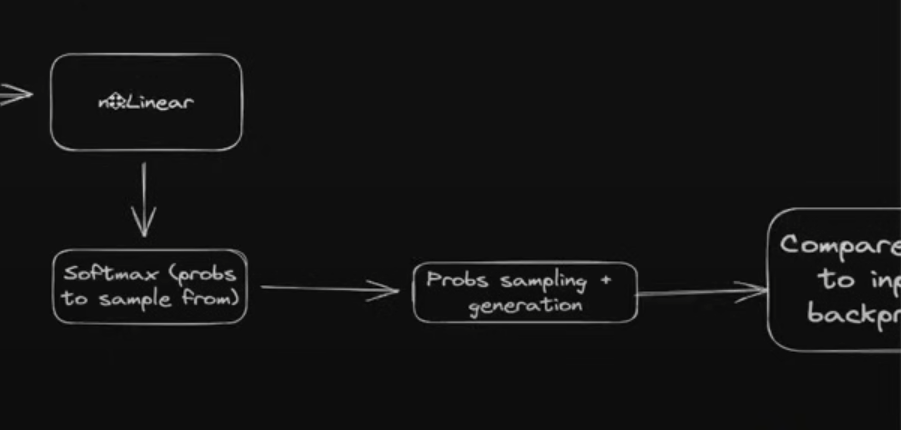

In [ ]:
class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #defining an embedding vector based on the vacab_size
        self.token_embeddeing_table=nn.Embedding(vocab_size, n_embed)

        #defining the position embedding
        self.position_embeddeing_table=nn.Embedding(block_size, n_embed)

        #defining the decoder block 
        self.block = nn.Sequential(*[Block(n_embed, n_head=n_head) for _ in range(n_layers) ] ) #creating the four decoder layers using the Block class
        self.ln_f = nn.LayerNorm(n_embed ) # final layer normalization
        self.lm_head = nn.Linear(n_embed, vocab_size )  #to build probablity distribution on each vocab_size 
        
        

    """ 
    below fucntion is used to compute the forward pass of the model and 
    compute the loss for a particular 
    """
    def forward(self, index, targets=None):
        #accessing the embedding vector for a paticular index token 
        logits = self.token_embeddeing_table(index)


        #extra code for GPT
        # idx and target are both (batch, time ) tensor 
        token_embeddeing_table = self.token_embeddeing_table(idx) #(batch, time, channel) tensor
        position_embedding_table = self.position_embeddeing_table(torch.arange(Time, device=device)) # (time, channel ) shape
        x = token_embeddeing_table + position_embedding_table
        #feeding the toekn and position embedding to the sequential network
        x = self.block(x) # (batch, time, channel)
        #performing linear operation from the output of decoder block
        x = self.ln_f(x) #(batch, time, channel)
        #generating the probablity distribution
        logits = self.lm_head() # (batch, time, vocab_size)
        

        if targets is None:
            loss=None
        else:
            #we unpack the dimension using the .shape
            batch, time, channel=logits.shape
            #we pack the dimension using the .view, we flattenr the batch and time into single dimension to compute loss 
            logits=logits.view(batch*time, channel)
            # we flattern the target vector to get loss
            targets=targets.view(batch*time)
            loss=F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # the index form is (batch, time ) in refrance to the current context
        for _ in range(max_new_tokens):
            #getting the pridition 
            logits, loss=self.forward(index)
            
            #getting the last time step
            logits=logits[:, -1, :] # to make it (batch,  channel)

            #applying softmax to the probablity distribution
            prob=F.softmax(logits, dim=-1) 

            #getting a sample from the distribution
            index_next= torch.multinomial(prob, num_samples=1)

            #appending the generated token to the preexisiting data
            index=torch.cat((index, index_next), dim=-1)
        return index
    

model=GPT(vocab_size)
m=model.to(device)

context=torch.zeros((1,1), dtype=torch.long, device=device)
generated_characters=decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_characters)
